# SRGAN

Ce notebook présente la modélisation SRGAN dans le cadre du projet 7 d'iml openclassrooms, il est associé à une présentation pdf disponible sur https://github.com/Loridan/openclassrooms-iml-projects

**référence**

Photo-Realistic Single Image Super-Resolution Using a Generative Adversarial Network
[2017 CVPR] [SRGAN & SRResNet]: 
https://arxiv.org/pdf/1609.04802.pdf

**librairies**

In [1]:
import glob
import shutil
import random
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from data import STFDOGS20580
from model.srgan import generator, discriminator
from train import SrganTrainer, SrganGeneratorTrainer

**paramètres GPU**

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')

for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

print("Nombre de GPU disponible : ", len(gpus))

Nombre de GPU disponible :  1


**paramètres divers**

In [3]:
# dossier sauvegarde des poids
WEIGHTS_DIR = 'weights/srgan'

# nombre d'images selectionnés aléatoirement dans le dataset
N_IMAGES = 5000

**fonctions diverses**

In [4]:
weights_file = lambda filename: os.path.join(WEIGHTS_DIR, filename)

**téléchargement du dataset / interpolation x4 / séparation des données**

la classe STFDOGS20580 s'occupe des données
les images sont stockées dans le dossier `.stfdogs20580` du répertoire racine du projet   
le dataset est téléchargé depuis le dépôt officiel et préparé automatiquement   
la fonction remove_data() supprime tous les données sur 'True'

In [5]:
stfdogs20580_train = STFDOGS20580(subset='train', n_images=N_IMAGES)
stfdogs20580_valid = STFDOGS20580(subset='valid', n_images=N_IMAGES)

In [6]:
stfdogs20580_train.remove_data(images_archive=False, images_preprocessed=False, cache=False)

In [7]:
train_ds = stfdogs20580_train.dataset(batch_size=16, random_transform=True)
valid_ds = stfdogs20580_valid.dataset(batch_size=16, random_transform=True, repeat_count=1)

**modélisations**

nous allons pré-entrainé le génerateur sur la fonction de perte MSE afin de fournir un générateur initialisé et puis nous allons améliorer la performance avec une méthode adverse

In [8]:
#Création du dossier pour les sauvegardes
os.makedirs(WEIGHTS_DIR, exist_ok=True)

**pré-entrainement du générateur sur MSE loss**

In [9]:
pre_trainer = SrganGeneratorTrainer(model=generator(), checkpoint_dir=f'.ckpt/pre_generator')
pre_trainer.train(train_ds,
                  valid_ds.take(100),
                  steps=20000, 
                  evaluate_every=1000, 
                  save_best_only=False)

pre_trainer.model.save_weights(weights_file('pre_generator.h5'))

1000/20000: loss_train = 695.528, loss_val = 455.302155, psnr_val = 22.832457 (99.92s)
2000/20000: loss_train = 471.605, loss_val = 451.819458, psnr_val = 23.171009 (92.54s)
3000/20000: loss_train = 439.607, loss_val = 406.658142, psnr_val = 23.792353 (92.14s)
4000/20000: loss_train = 427.463, loss_val = 389.210876, psnr_val = 24.158199 (92.76s)
5000/20000: loss_train = 414.197, loss_val = 394.336487, psnr_val = 24.186033 (92.69s)
6000/20000: loss_train = 400.656, loss_val = 385.960175, psnr_val = 23.474201 (92.33s)
7000/20000: loss_train = 396.774, loss_val = 396.300751, psnr_val = 24.632648 (92.65s)
8000/20000: loss_train = 390.889, loss_val = 391.532104, psnr_val = 24.041616 (92.92s)
9000/20000: loss_train = 391.229, loss_val = 379.361420, psnr_val = 24.671635 (92.87s)
10000/20000: loss_train = 386.358, loss_val = 367.339905, psnr_val = 24.556221 (92.63s)
11000/20000: loss_train = 381.680, loss_val = 366.331238, psnr_val = 25.380821 (92.70s)
12000/20000: loss_train = 380.388, loss_v

**entrainement du générateur et discriminateur sur perception loss**

In [10]:
gan_generator = generator()
gan_generator.load_weights(weights_file('pre_generator.h5'))

gan_trainer = SrganTrainer(generator=gan_generator, discriminator=discriminator())
gan_trainer.train(train_ds,
                  steps=5000)

50/5000, perceptual loss = 0.3458, discriminator loss = 1.5015
100/5000, perceptual loss = 0.3289, discriminator loss = 0.2646
150/5000, perceptual loss = 0.3325, discriminator loss = 0.5198
200/5000, perceptual loss = 0.3393, discriminator loss = 0.2197
250/5000, perceptual loss = 0.3273, discriminator loss = 0.2167
300/5000, perceptual loss = 0.3232, discriminator loss = 0.1110
350/5000, perceptual loss = 0.3347, discriminator loss = 0.0097
400/5000, perceptual loss = 0.3277, discriminator loss = 0.0107
450/5000, perceptual loss = 0.3087, discriminator loss = 0.0424
500/5000, perceptual loss = 0.3103, discriminator loss = 0.0081
550/5000, perceptual loss = 0.3418, discriminator loss = 0.1650
600/5000, perceptual loss = 0.3221, discriminator loss = 0.0218
650/5000, perceptual loss = 0.3093, discriminator loss = 0.0098
700/5000, perceptual loss = 0.3162, discriminator loss = 0.3246
750/5000, perceptual loss = 0.3170, discriminator loss = 0.0511
800/5000, perceptual loss = 0.3443, discr

In [11]:
gan_trainer.generator.save_weights(weights_file('gan_generator.h5'))
gan_trainer.discriminator.save_weights(weights_file('gan_discriminator.h5'))

**visualisation des performances**

In [12]:
pre_generator = generator()
gan_generator = generator()

pre_generator.load_weights(weights_file('pre_generator.h5'))
gan_generator.load_weights(weights_file('gan_generator.h5'))

In [13]:
from model import resolve_single
from utils import load_image

def resolve_and_plot(lr_image_path):
    lr = load_image(lr_image_path)
    
    pre_sr = resolve_single(pre_generator, lr)
    gan_sr = resolve_single(gan_generator, lr)
    
    plt.figure(figsize=(20, 20))
    
    images = [lr, pre_sr, gan_sr]
    titles = ['LR', 'SR (PRE)', 'SR (GAN)']
    positions = [1, 3, 4]
    
    for i, (img, title, pos) in enumerate(zip(images, titles, positions)):
        plt.subplot(2, 2, pos)
        plt.imshow(img)
        plt.title(title)
        plt.xticks([])
        plt.yticks([])

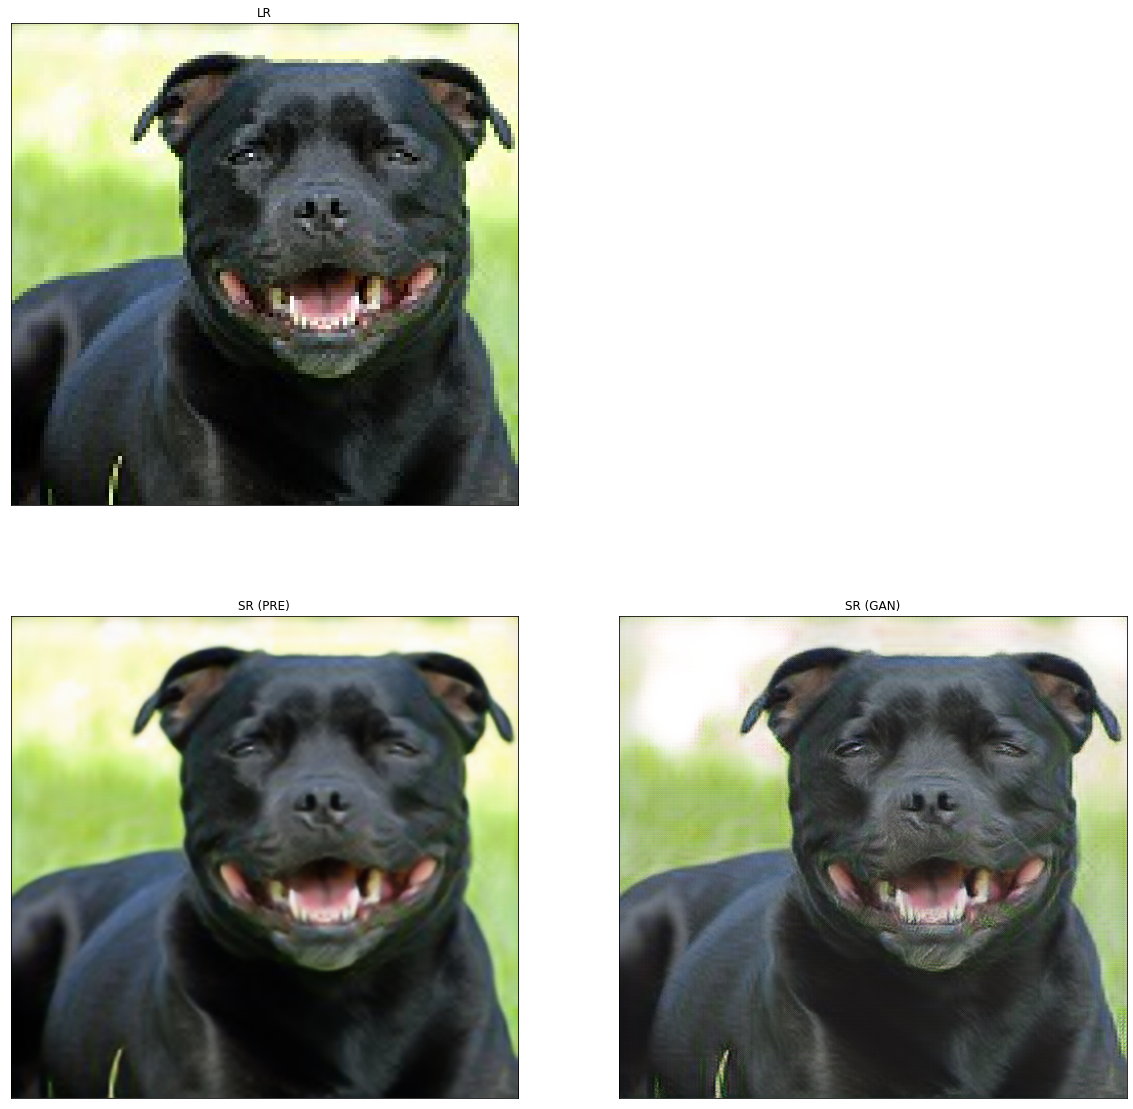

In [14]:
resolve_and_plot('demo/dog-crop.jpg')

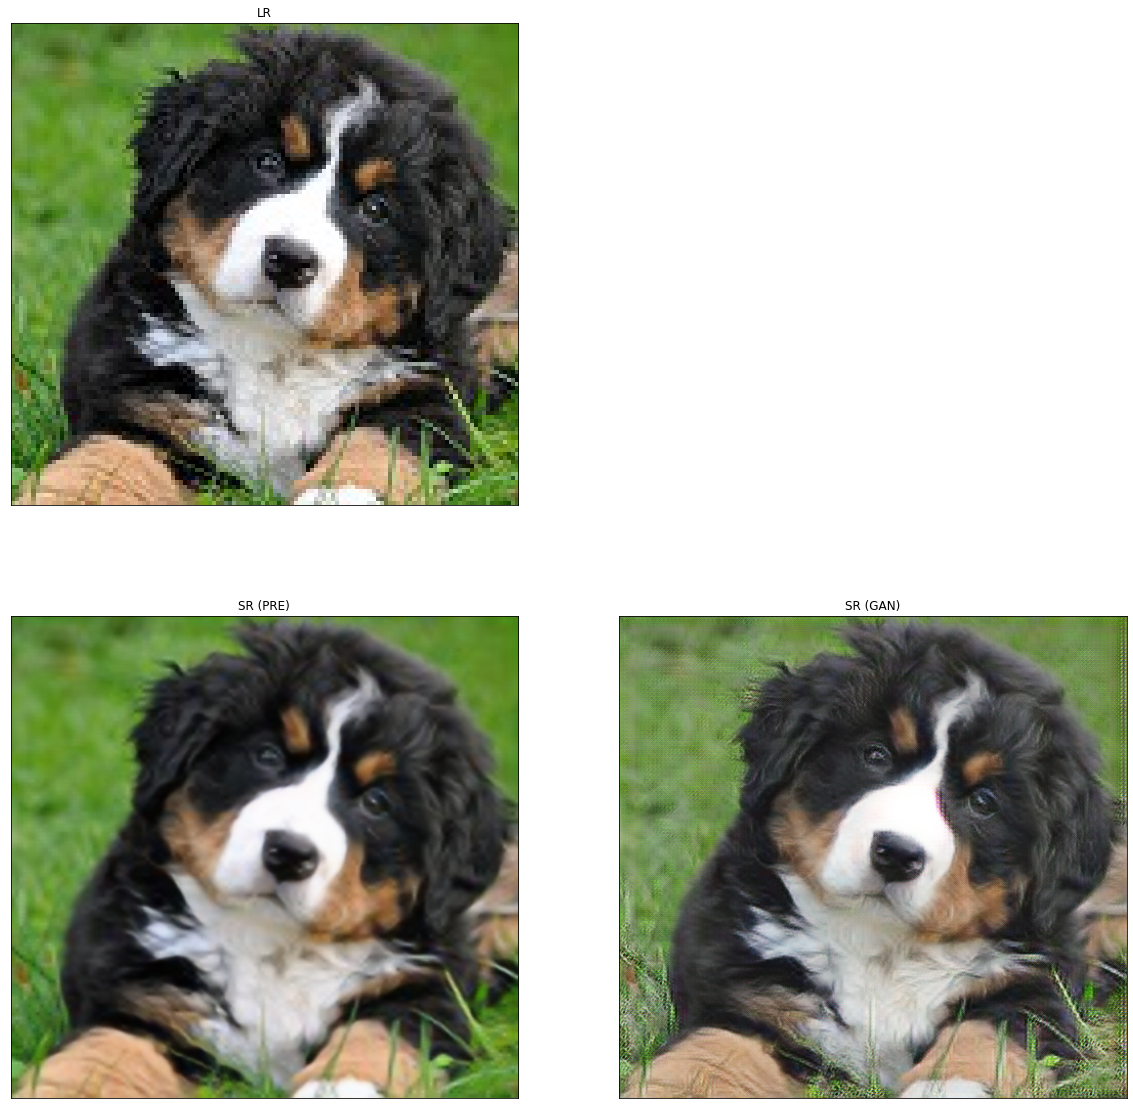

In [15]:
resolve_and_plot('demo/dog-crop2.jpg')